# A

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('BBBP.csv')
df.drop(['num'], axis=1, inplace=True)
df['length'] = df['smiles'].str.len()
df.head()

,name,p_np,smiles,length
0,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,32
1,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,40
2,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,50
3,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,32
4,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,66


In [2]:
df.describe()

,p_np,length
count,2050.000000,2050.000000
mean,0.764390,51.474146
std,0.424483,30.620659
min,0.000000,3.000000
25%,1.000000,33.000000
50%,1.000000,45.000000
75%,1.000000,61.000000
max,1.000000,400.000000


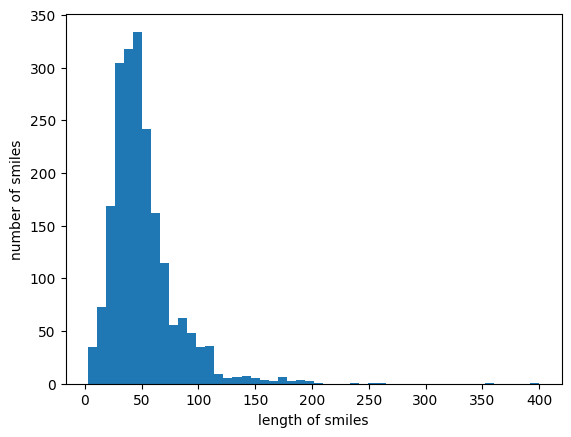

In [3]:
plt.hist(df['length'], bins=50)
plt.xlabel('length of smiles')
plt.ylabel('number of smiles')
plt.show()

Most SMILES data are between 20 to 60 characters long. The average length is 50 characters. the longest is 400 characters long which we'll use as our one-hot enocding length for fully connected network.

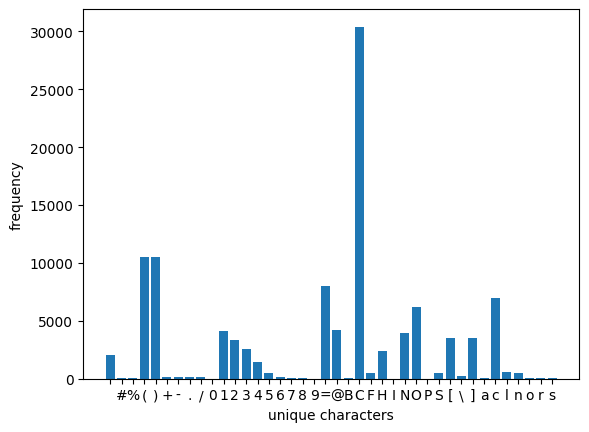

In [4]:
joined_smiles = ' '.join(df['smiles'].tolist())
unique_chars = sorted(list(set(joined_smiles)))
char_freq = []
for char in unique_chars:
    char_freq.append(joined_smiles.count(char))
plt.bar(unique_chars, char_freq)
plt.xlabel('unique characters')
plt.ylabel('frequency')
plt.show()

40 tokens with `C` token being the most frequent. `(` and `)` are at the second and third place.

# B

We one-hot encode each character in the smiles and concatenate all the one-hot vectors to form a single vector. We then feed this vector to a fully connected neural network with 2 hidden layers. The output of the network is a single value between 0 and 1, which we interpret as the probability that the molecule is active.

In [5]:
import numpy as np

def one_hot_encode(smiles):
    char_to_int = dict((c, i) for i, c in enumerate(unique_chars))
    integer_encoded = [char_to_int[char] for char in smiles]
    onehot_encoded = list()
    for value in integer_encoded:
        letter = [0 for _ in range(len(unique_chars))]
        letter[value] = 1
        onehot_encoded.append(letter)
    return np.array(onehot_encoded)

one_hot_encodes = np.zeros((len(df['smiles']), max(df['length']), len(unique_chars)), dtype=np.int8)
for i, smiles in enumerate(df['smiles']):
    one_hot_encodes[i, :len(smiles), :] = one_hot_encode(smiles)
one_hot_encodes = one_hot_encodes.reshape(one_hot_encodes.shape[0], -1)

In [6]:
import torch
from torch import nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
from torch.utils.data import DataLoader, TensorDataset, random_split, ConcatDataset

dataset = TensorDataset(torch.tensor(one_hot_encodes, dtype=torch.float32), torch.tensor(df['p_np'].values, dtype=torch.float32))
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_f1_dataset, train_f2_dataset, train_f3_dataset, train_f4_dataset = random_split(train_dataset, [train_size // 4] * 3 + [train_size - train_size // 4 * 3])
train_loaders = [
    DataLoader(ConcatDataset([train_f2_dataset, train_f3_dataset, train_f4_dataset]), batch_size=64, shuffle=True),
    DataLoader(ConcatDataset([train_f1_dataset, train_f3_dataset, train_f4_dataset]), batch_size=64, shuffle=True),
    DataLoader(ConcatDataset([train_f1_dataset, train_f2_dataset, train_f4_dataset]), batch_size=64, shuffle=True),
    DataLoader(ConcatDataset([train_f1_dataset, train_f2_dataset, train_f3_dataset]), batch_size=64, shuffle=True),
    DataLoader(train_dataset, batch_size=64, shuffle=True),
]
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loaders = [
    DataLoader(train_f1_dataset, batch_size=64, shuffle=False),
    DataLoader(train_f2_dataset, batch_size=64, shuffle=False),
    DataLoader(train_f3_dataset, batch_size=64, shuffle=False),
    DataLoader(train_f4_dataset, batch_size=64, shuffle=False),
    test_loader,
]

In [8]:
class FC(nn.Module):
    def __init__(self, input_size, output_size):
        super(FC, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.sigmoid(x)

In [9]:
import torch.optim as optim
from tqdm import tqdm, trange
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def train_fc(net, train_loader, optimizer, criterion):
    net.train()
    losses = []
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

def test_fc(net, test_loader, criterion):
    net.eval()
    losses = []
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs.squeeze(), labels)
            losses.append(loss.item())
            predicted = torch.round(outputs.squeeze())
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())
    return np.mean(losses), y_pred, y_true

def evaluate(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Fold 1 Epoch 25 Train loss: 0.0067: 100%|██████████| 25/25 [00:03<00:00,  7.50it/s]


Train loss: 0.0063
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       296
         1.0       1.00      1.00      1.00       934

    accuracy                           1.00      1230
   macro avg       1.00      1.00      1.00      1230
weighted avg       1.00      1.00      1.00      1230



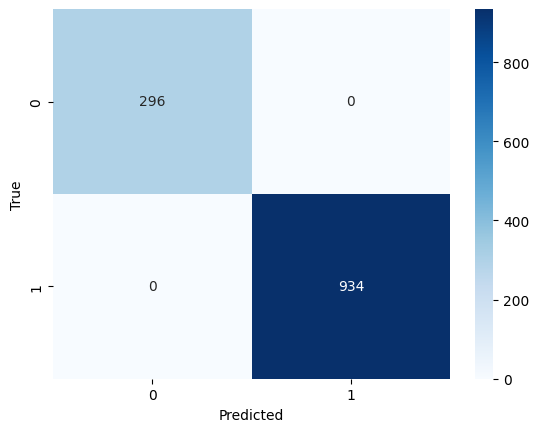

Val loss: 0.5645
              precision    recall  f1-score   support

         0.0       0.74      0.63      0.68        97
         1.0       0.89      0.93      0.91       313

    accuracy                           0.86       410
   macro avg       0.82      0.78      0.80       410
weighted avg       0.86      0.86      0.86       410



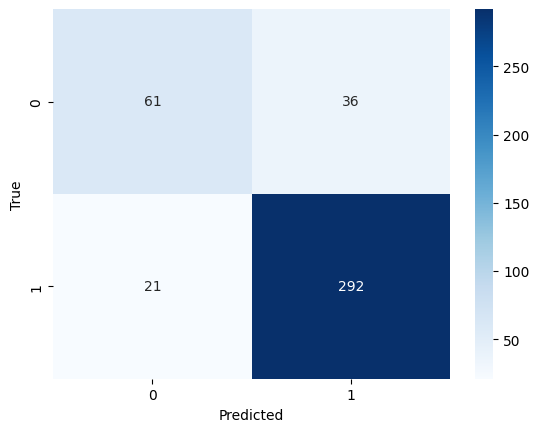

Fold 2 Epoch 25 Train loss: 0.0094: 100%|██████████| 25/25 [00:02<00:00,  9.92it/s]


Train loss: 0.0095
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       297
         1.0       1.00      1.00      1.00       933

    accuracy                           1.00      1230
   macro avg       1.00      1.00      1.00      1230
weighted avg       1.00      1.00      1.00      1230



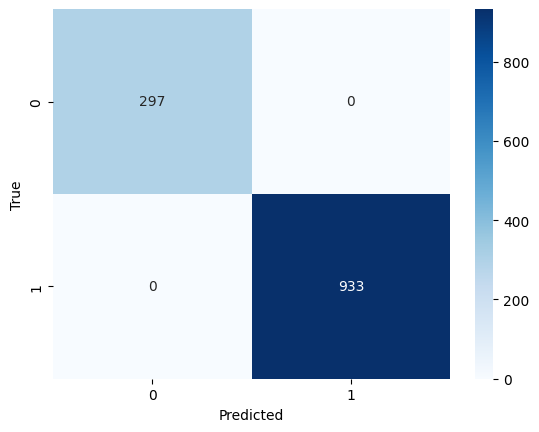

Val loss: 0.4727
              precision    recall  f1-score   support

         0.0       0.72      0.67      0.69        96
         1.0       0.90      0.92      0.91       314

    accuracy                           0.86       410
   macro avg       0.81      0.79      0.80       410
weighted avg       0.86      0.86      0.86       410



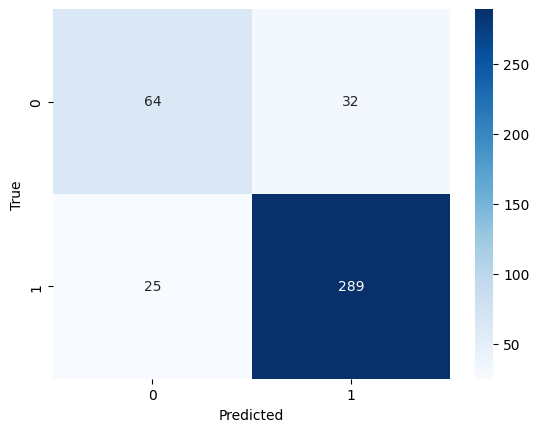

Fold 3 Epoch 25 Train loss: 0.0084: 100%|██████████| 25/25 [00:02<00:00,  8.68it/s]


Train loss: 0.0083
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       294
         1.0       1.00      1.00      1.00       936

    accuracy                           1.00      1230
   macro avg       1.00      1.00      1.00      1230
weighted avg       1.00      1.00      1.00      1230



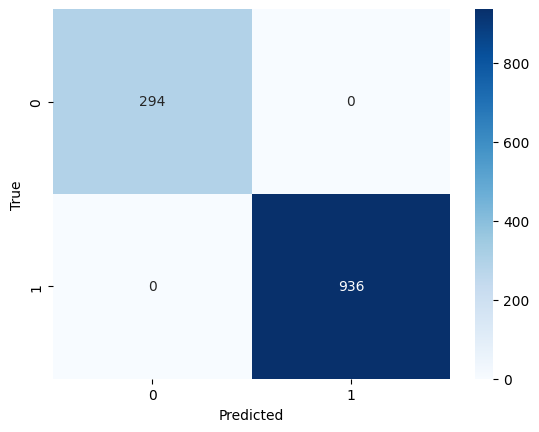

Val loss: 0.6235
              precision    recall  f1-score   support

         0.0       0.79      0.61      0.69        99
         1.0       0.88      0.95      0.91       311

    accuracy                           0.87       410
   macro avg       0.84      0.78      0.80       410
weighted avg       0.86      0.87      0.86       410



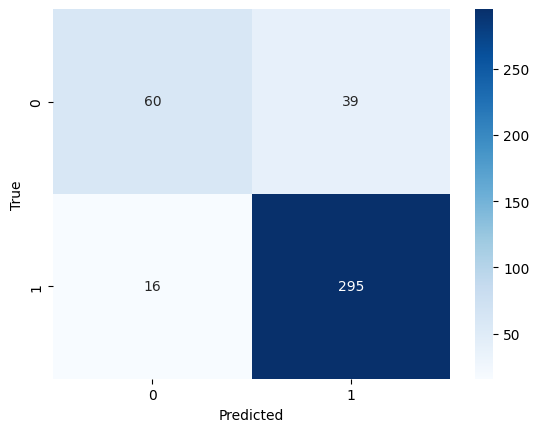

Fold 4 Epoch 25 Train loss: 0.0082: 100%|██████████| 25/25 [00:03<00:00,  8.10it/s]


Train loss: 0.0079
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       292
         1.0       1.00      1.00      1.00       938

    accuracy                           1.00      1230
   macro avg       1.00      1.00      1.00      1230
weighted avg       1.00      1.00      1.00      1230



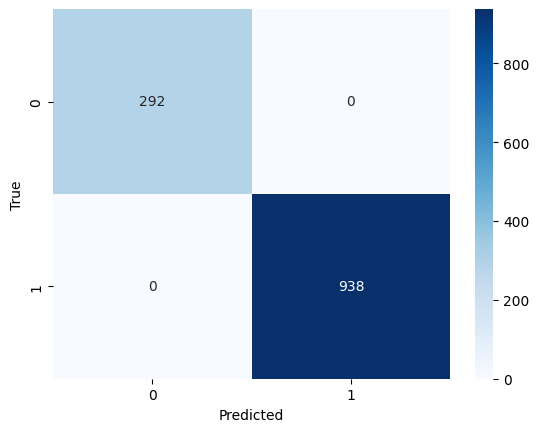

Val loss: 0.5708
              precision    recall  f1-score   support

         0.0       0.67      0.65      0.66       101
         1.0       0.89      0.90      0.89       309

    accuracy                           0.84       410
   macro avg       0.78      0.77      0.78       410
weighted avg       0.84      0.84      0.84       410



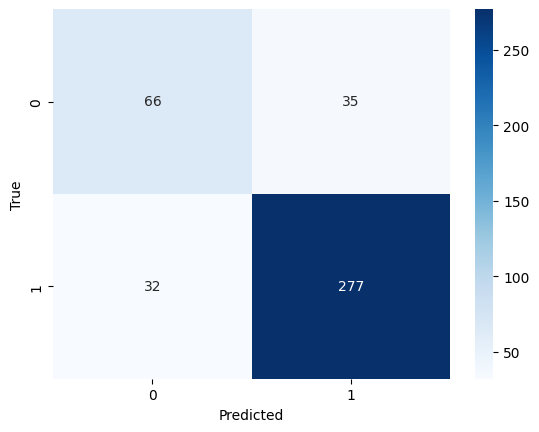

Fold 5 Epoch 25 Train loss: 0.0063: 100%|██████████| 25/25 [00:03<00:00,  6.78it/s]


Train loss: 0.0057
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       393
         1.0       1.00      1.00      1.00      1247

    accuracy                           1.00      1640
   macro avg       1.00      1.00      1.00      1640
weighted avg       1.00      1.00      1.00      1640



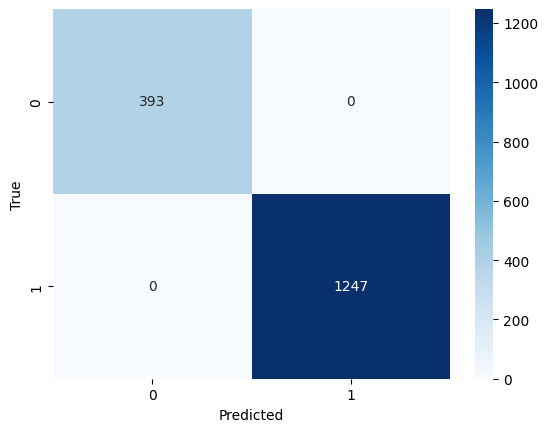

Val loss: 0.5815
              precision    recall  f1-score   support

         0.0       0.67      0.62      0.65        90
         1.0       0.90      0.92      0.91       320

    accuracy                           0.85       410
   macro avg       0.79      0.77      0.78       410
weighted avg       0.85      0.85      0.85       410



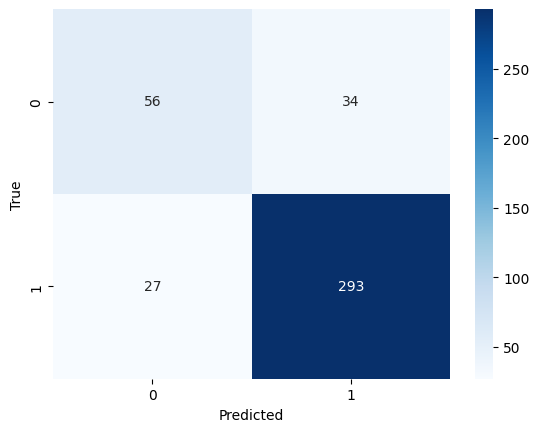

In [10]:
epochs = 25
criterion = nn.BCELoss()
for i, (train_loader, val_loader) in enumerate(zip(train_loaders, val_loaders)):
    
    fc = FC(one_hot_encodes.shape[1], 1).to(device)
    optimizer = optim.Adam(fc.parameters(), lr=0.001)

    pbar = trange(epochs)
    for epoch in pbar:
        train_loss = train_fc(fc, train_loader, optimizer, criterion)
        pbar.set_description(f'Fold {i + 1} Epoch {epoch + 1} Train loss: {train_loss:.4f}')

    train_loss, y_pred, y_true = test_fc(fc, train_loader, criterion)
    print(f'Train loss: {train_loss:.4f}')
    evaluate(y_true, y_pred)

    val_loss, y_pred, y_true = test_fc(fc, val_loader, criterion)
    print(f'Val loss: {val_loss:.4f}')
    evaluate(y_true, y_pred)

## Mean Test Accuracy of 4 folds cross validation: 83%

# C

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size, 1, batch_first=True)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm1(x, (h0, c0))
        return out

class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [12]:
def train_seq(net, lstm, train_loader, optimizer, criterion):
    net.train()
    lstm.train()
    losses = []
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.reshape(inputs.shape[0], 400, 40)
        inputs, labels = inputs.to(device), labels.to(device)
        lstm_out = lstm(inputs)
        lstm_out = lstm_out.reshape(lstm_out.shape[0], -1)
        optimizer.zero_grad()
        outputs = net(lstm_out)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

def test_seq(net, lstm, test_loader, criterion):
    net.eval()
    lstm.eval()
    losses = []
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.reshape(inputs.shape[0], 400, 40)
            inputs, labels = inputs.to(device), labels.to(device)
            lstm_out = lstm(inputs)
            lstm_out = lstm_out.reshape(lstm_out.shape[0], -1)
            outputs = net(lstm_out)
            loss = criterion(outputs.squeeze(), labels)
            losses.append(loss.item())
            predicted = torch.round(outputs.squeeze())
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())
    return np.mean(losses), y_pred, y_true

Fold 1 Epoch 100 Train loss: 0.1383: 100%|██████████| 100/100 [00:30<00:00,  3.25it/s]


Train loss: 0.1080
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.93       296
         1.0       0.99      0.96      0.98       934

    accuracy                           0.96      1230
   macro avg       0.94      0.96      0.95      1230
weighted avg       0.96      0.96      0.96      1230



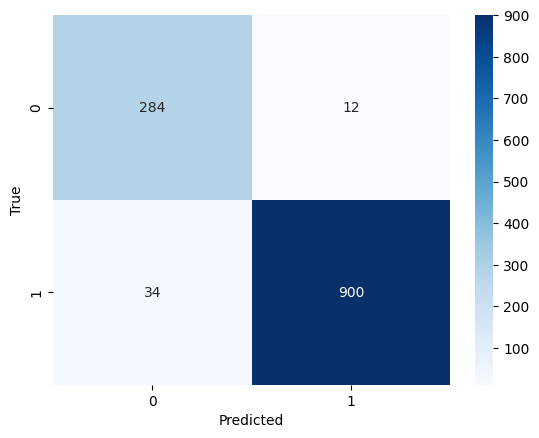

Val loss: 0.2836
              precision    recall  f1-score   support

         0.0       0.69      0.72      0.71        97
         1.0       0.91      0.90      0.91       313

    accuracy                           0.86       410
   macro avg       0.80      0.81      0.81       410
weighted avg       0.86      0.86      0.86       410



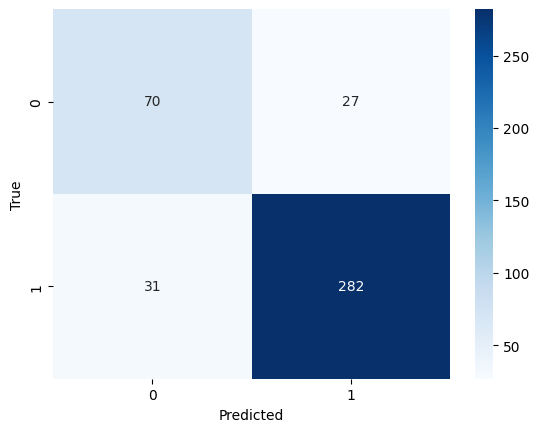

Fold 2 Epoch 100 Train loss: 0.1508: 100%|██████████| 100/100 [00:32<00:00,  3.06it/s]


Train loss: 0.0983
              precision    recall  f1-score   support

         0.0       0.98      0.86      0.92       297
         1.0       0.96      1.00      0.98       933

    accuracy                           0.96      1230
   macro avg       0.97      0.93      0.95      1230
weighted avg       0.96      0.96      0.96      1230



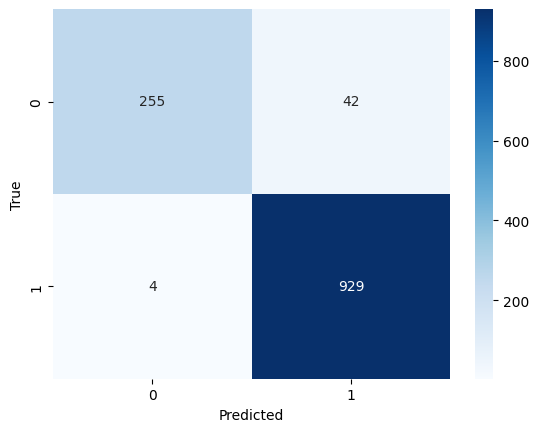

Val loss: 0.3075
              precision    recall  f1-score   support

         0.0       0.77      0.65      0.70        96
         1.0       0.90      0.94      0.92       314

    accuracy                           0.87       410
   macro avg       0.83      0.79      0.81       410
weighted avg       0.87      0.87      0.87       410



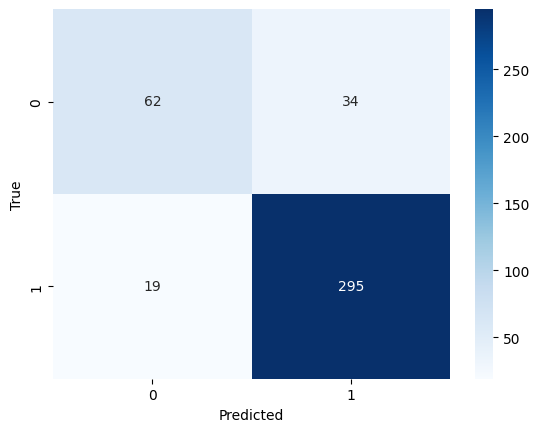

Fold 3 Epoch 100 Train loss: 0.0938: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Train loss: 0.1356
              precision    recall  f1-score   support

         0.0       0.79      0.98      0.87       294
         1.0       0.99      0.92      0.95       936

    accuracy                           0.93      1230
   macro avg       0.89      0.95      0.91      1230
weighted avg       0.94      0.93      0.93      1230



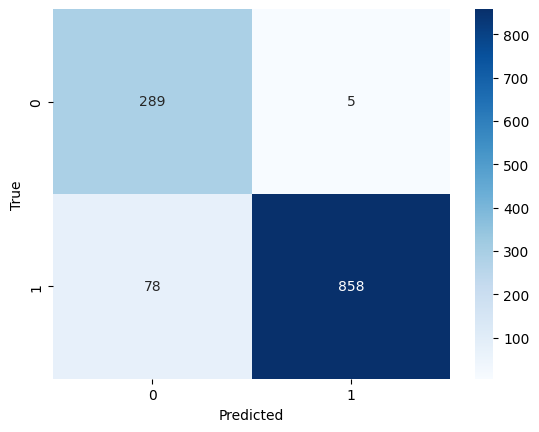

Val loss: 0.3943
              precision    recall  f1-score   support

         0.0       0.67      0.82      0.74        99
         1.0       0.94      0.87      0.90       311

    accuracy                           0.86       410
   macro avg       0.80      0.84      0.82       410
weighted avg       0.87      0.86      0.86       410



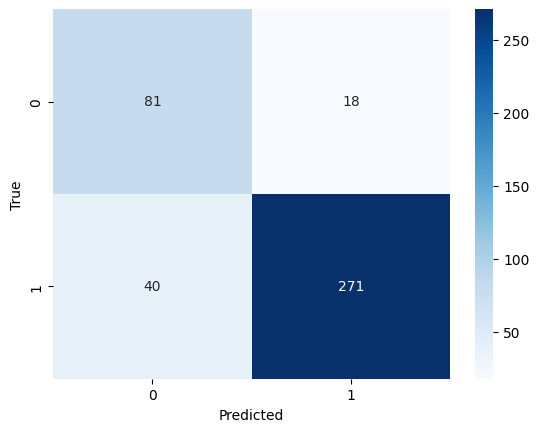

Fold 4 Epoch 100 Train loss: 0.1315: 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


Train loss: 0.0744
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95       292
         1.0       0.98      0.99      0.99       938

    accuracy                           0.98      1230
   macro avg       0.98      0.96      0.97      1230
weighted avg       0.98      0.98      0.98      1230



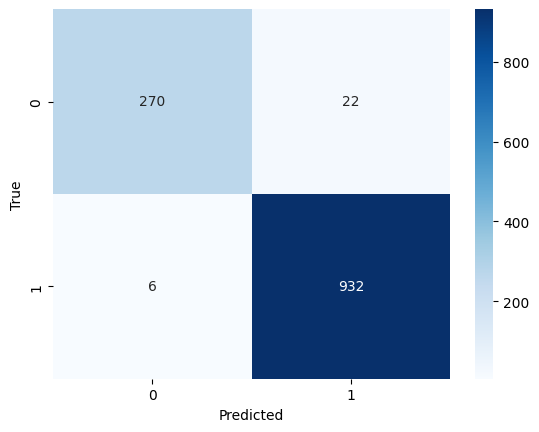

Val loss: 0.3845
              precision    recall  f1-score   support

         0.0       0.73      0.67      0.70       101
         1.0       0.90      0.92      0.91       309

    accuracy                           0.86       410
   macro avg       0.81      0.80      0.80       410
weighted avg       0.86      0.86      0.86       410



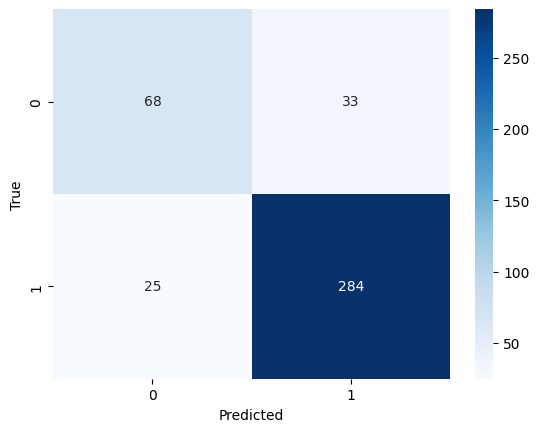

Fold 5 Epoch 100 Train loss: 0.1441: 100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Train loss: 0.1178
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91       393
         1.0       0.99      0.95      0.97      1247

    accuracy                           0.95      1640
   macro avg       0.92      0.96      0.94      1640
weighted avg       0.96      0.95      0.95      1640



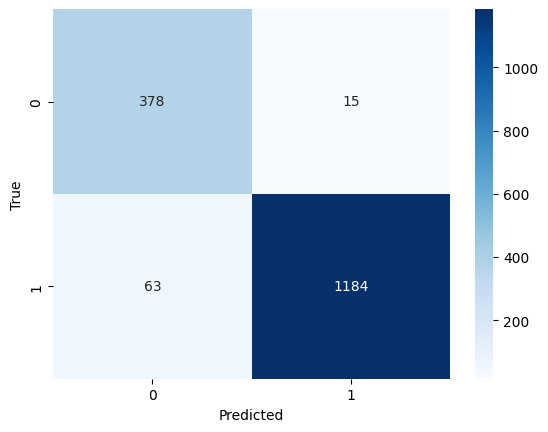

Val loss: 0.2809
              precision    recall  f1-score   support

         0.0       0.69      0.84      0.76        90
         1.0       0.95      0.89      0.92       320

    accuracy                           0.88       410
   macro avg       0.82      0.87      0.84       410
weighted avg       0.90      0.88      0.89       410



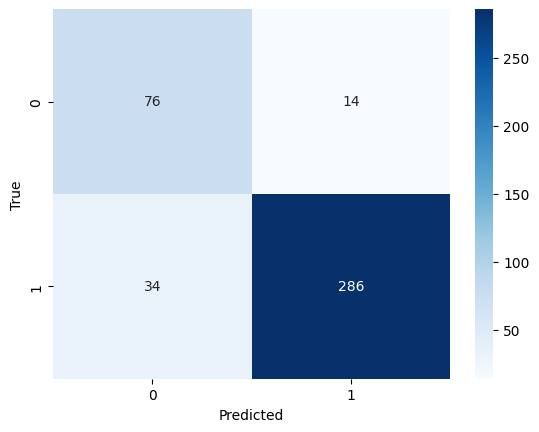

In [13]:
criterion = nn.BCELoss()
epochs = 100

for i, (train_loader, val_loader) in enumerate(zip(train_loaders, val_loaders)):
    
    lstm = LSTM(40, 128).to(device)
    lstm_net = MLP(400 * 128, 1).to(device)
    optimizer = optim.Adam(lstm_net.parameters(), lr=0.001)

    pbar = trange(epochs)
    for epoch in pbar:
        train_loss = train_seq(lstm_net, lstm, train_loader, optimizer, criterion)
        pbar.set_description(f'Fold {i + 1} Epoch {epoch + 1} Train loss: {train_loss:.4f}')

    train_loss, y_pred, y_true = test_seq(lstm_net, lstm, train_loader, criterion)
    print(f'Train loss: {train_loss:.4f}')
    evaluate(y_true, y_pred)

    val_loss, y_pred, y_true = test_seq(lstm_net, lstm, val_loader, criterion)
    print(f'Val loss: {val_loss:.4f}')
    evaluate(y_true, y_pred)

## Mean Test Accuracy of 5 folds cross validation: 85%

# D

In [14]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size, 1, batch_first=True, bidirectional=True)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(2, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm1(x, (h0, c0))
        return out

Fold 1 Epoch 100 Train loss: 0.1275: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Train loss: 0.0868
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94       296
         1.0       0.98      0.98      0.98       934

    accuracy                           0.97      1230
   macro avg       0.96      0.96      0.96      1230
weighted avg       0.97      0.97      0.97      1230



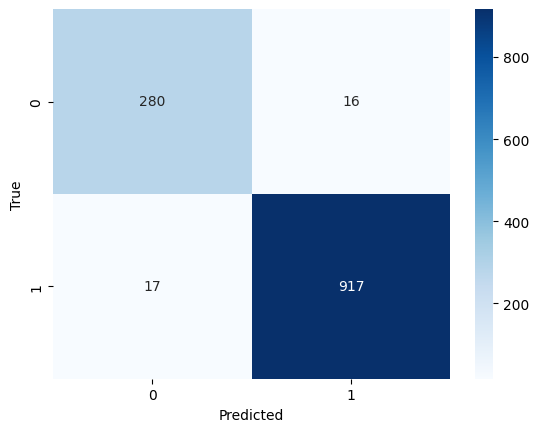

Val loss: 0.3020
              precision    recall  f1-score   support

         0.0       0.73      0.65      0.69        97
         1.0       0.90      0.93      0.91       313

    accuracy                           0.86       410
   macro avg       0.81      0.79      0.80       410
weighted avg       0.86      0.86      0.86       410



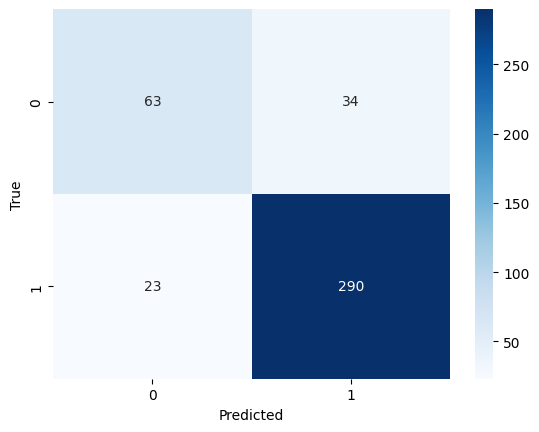

Fold 2 Epoch 100 Train loss: 0.0934: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Train loss: 0.0818
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94       297
         1.0       0.97      1.00      0.98       933

    accuracy                           0.97      1230
   macro avg       0.98      0.95      0.96      1230
weighted avg       0.97      0.97      0.97      1230



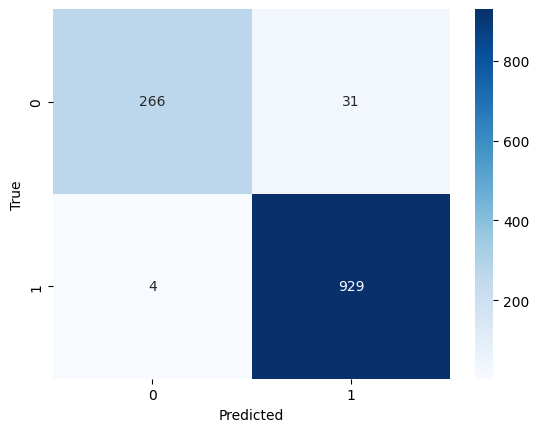

Val loss: 0.3520
              precision    recall  f1-score   support

         0.0       0.74      0.59      0.66        96
         1.0       0.88      0.94      0.91       314

    accuracy                           0.86       410
   macro avg       0.81      0.77      0.78       410
weighted avg       0.85      0.86      0.85       410



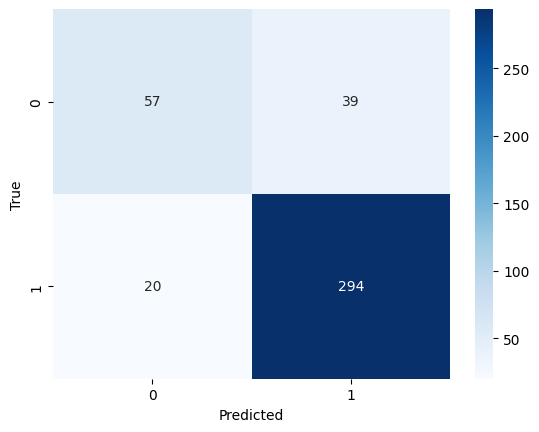

Fold 3 Epoch 100 Train loss: 0.0835: 100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


Train loss: 0.0849
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94       294
         1.0       0.97      1.00      0.98       936

    accuracy                           0.97      1230
   macro avg       0.98      0.95      0.96      1230
weighted avg       0.97      0.97      0.97      1230



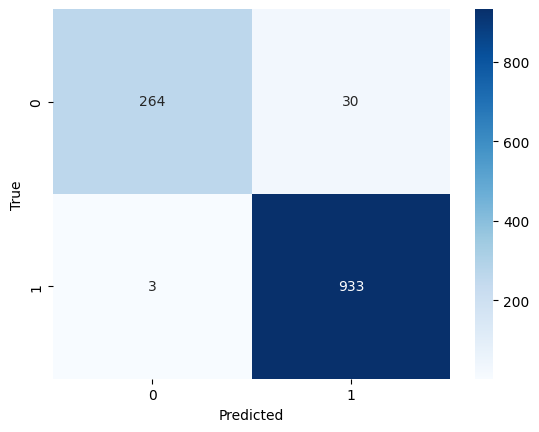

Val loss: 0.3949
              precision    recall  f1-score   support

         0.0       0.77      0.66      0.71        99
         1.0       0.90      0.94      0.92       311

    accuracy                           0.87       410
   macro avg       0.83      0.80      0.81       410
weighted avg       0.87      0.87      0.87       410



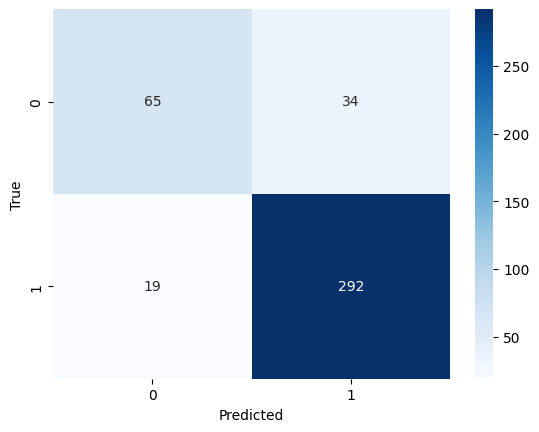

Fold 4 Epoch 100 Train loss: 0.0883: 100%|██████████| 100/100 [00:49<00:00,  2.00it/s]


Train loss: 0.0683
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95       292
         1.0       0.97      1.00      0.99       938

    accuracy                           0.98      1230
   macro avg       0.98      0.96      0.97      1230
weighted avg       0.98      0.98      0.98      1230



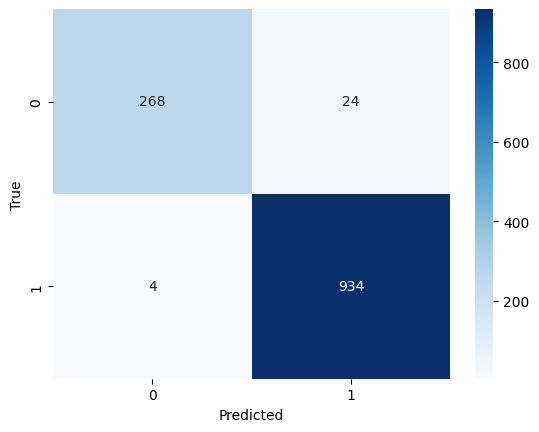

Val loss: 0.3921
              precision    recall  f1-score   support

         0.0       0.73      0.66      0.69       101
         1.0       0.89      0.92      0.91       309

    accuracy                           0.86       410
   macro avg       0.81      0.79      0.80       410
weighted avg       0.85      0.86      0.85       410



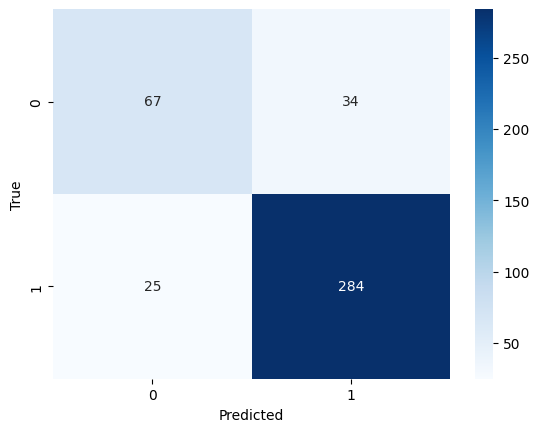

Fold 5 Epoch 100 Train loss: 0.1075: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


Train loss: 0.0938
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91       393
         1.0       0.95      1.00      0.98      1247

    accuracy                           0.96      1640
   macro avg       0.97      0.92      0.95      1640
weighted avg       0.96      0.96      0.96      1640



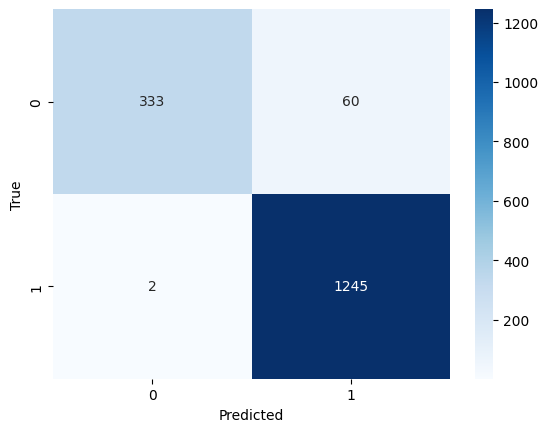

Val loss: 0.3214
              precision    recall  f1-score   support

         0.0       0.82      0.62      0.71        90
         1.0       0.90      0.96      0.93       320

    accuracy                           0.89       410
   macro avg       0.86      0.79      0.82       410
weighted avg       0.88      0.89      0.88       410



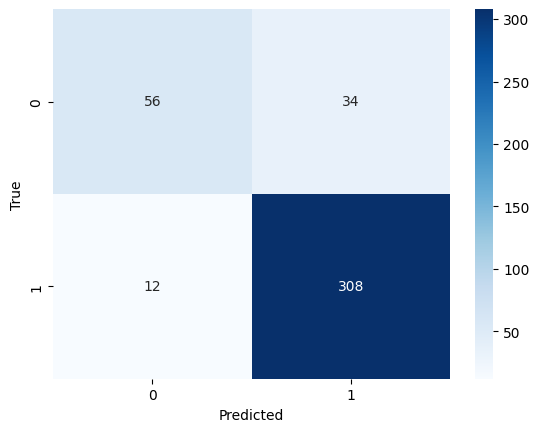

In [15]:
criterion = nn.BCELoss()
epochs = 100

for i, (train_loader, val_loader) in enumerate(zip(train_loaders, val_loaders)):
    
    bilstm = BiLSTM(40, 128).to(device)
    bilstm_net = MLP(400 * 128 * 2, 1).to(device)
    optimizer = optim.Adam(bilstm_net.parameters(), lr=0.001)

    pbar = trange(epochs)
    for epoch in pbar:
        train_loss = train_seq(bilstm_net, bilstm, train_loader, optimizer, criterion)
        pbar.set_description(f'Fold {i + 1} Epoch {epoch + 1} Train loss: {train_loss:.4f}')

    train_loss, y_pred, y_true = test_seq(bilstm_net, bilstm, train_loader, criterion)
    print(f'Train loss: {train_loss:.4f}')
    evaluate(y_true, y_pred)

    val_loss, y_pred, y_true = test_seq(bilstm_net, bilstm, val_loader, criterion)
    print(f'Val loss: {val_loss:.4f}')
    evaluate(y_true, y_pred)

## Mean Test Accuracy of 4 folds cross validation: 86%

# E

Bidirectional LSTM gets better results than LSTM and LSTM gets better results than Fully Connected Neural Network. This is because LSTM and Bidirectional LSTM are able to capture the sequential nature of the data. LSTM is able to capture the sequential nature of the data in one direction while Bidirectional LSTM is able to capture the sequential nature of the data in both directions. Fully Connected Neural Network is not able to capture the sequential nature of the data.

Bidirectional LSTM gets better results on longer sequences than LSTM. This is because Bidirectional LSTM is capturing the sequential nature of the data in both directions while LSTM is capturing the sequential nature of the data in one direction and this causes LSTM to forget information from the beginning of the sequence while Bidirectional LSTM does not forget information from the beginning of the sequence.

# F

In [22]:
df['bins'] = pd.cut(df['length'], 10, labels=False)
bins = []
for i in range(10):
    bins.append(df[df['bins'] == i])
bins_one_hot_encodes = []
for bin in bins:
    if len(bin) == 0:
        bins_one_hot_encodes.append([])
        continue
    one_hot_encodes = np.zeros((len(bin), 400, 40), dtype=np.int8)
    for i, smiles in enumerate(bin['smiles']):
        one_hot_encodes[i, :len(smiles), :] = one_hot_encode(smiles)
    one_hot_encodes = one_hot_encodes.reshape(one_hot_encodes.shape[0], -1)
    bins_one_hot_encodes.append(one_hot_encodes)
bins_datasets = []
for i, bin in enumerate(bins):
    dataset = TensorDataset(torch.tensor(bins_one_hot_encodes[i], dtype=torch.float32), torch.tensor(bin['p_np'].values, dtype=torch.float32))
    bins_datasets.append(dataset)

In [23]:
def test_fc(net, test_loader, criterion):
    net.eval()
    losses = []
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs.squeeze(), labels)
            losses.append(loss.item())
            predicted = torch.round(outputs.squeeze())
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())
    return np.mean(losses), y_pred, y_true

def test_seq(net, lstm, test_loader, criterion):
    net.eval()
    lstm.eval()
    losses = []
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.reshape(inputs.shape[0], 400, 40)
            inputs, labels = inputs.to(device), labels.to(device)
            lstm_out = lstm(inputs)
            lstm_out = lstm_out.reshape(lstm_out.shape[0], -1)
            outputs = net(lstm_out)
            loss = criterion(outputs.squeeze(), labels)
            losses.append(loss.item())
            predicted = torch.round(outputs.squeeze())
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())
    return np.mean(losses), y_pred, y_true

BIN: 0 - 899 samples
FC Test loss: 0.0992
              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87       116
         1.0       0.98      0.98      0.98       783

    accuracy                           0.97       899
   macro avg       0.92      0.93      0.93       899
weighted avg       0.97      0.97      0.97       899



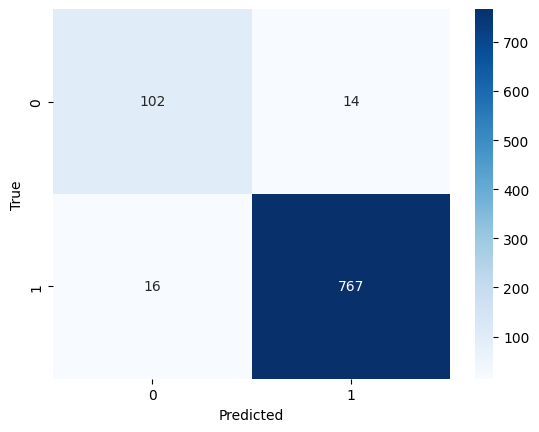

LSTM Test loss: 0.1779
              precision    recall  f1-score   support

         0.0       0.65      0.84      0.73       116
         1.0       0.97      0.93      0.95       783

    accuracy                           0.92       899
   macro avg       0.81      0.88      0.84       899
weighted avg       0.93      0.92      0.92       899



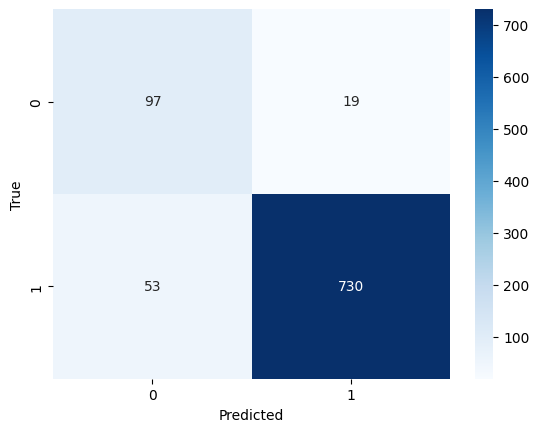

BiLSTM Test loss: 0.1667
              precision    recall  f1-score   support

         0.0       0.89      0.47      0.61       116
         1.0       0.93      0.99      0.96       783

    accuracy                           0.92       899
   macro avg       0.91      0.73      0.78       899
weighted avg       0.92      0.92      0.91       899



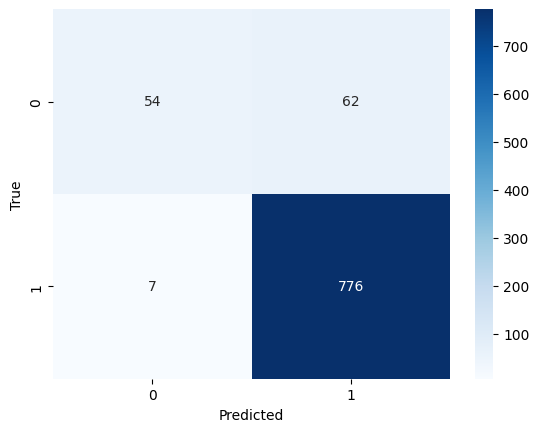

BIN: 1 - 909 samples
FC Test loss: 0.1251
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95       260
         1.0       0.97      0.99      0.98       649

    accuracy                           0.97       909
   macro avg       0.97      0.96      0.96       909
weighted avg       0.97      0.97      0.97       909



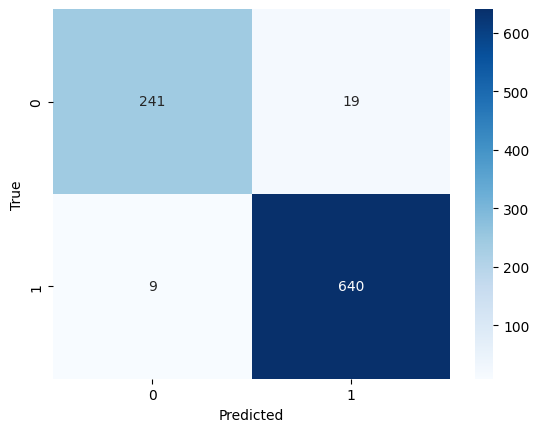

LSTM Test loss: 0.1307
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92       260
         1.0       0.98      0.95      0.96       649

    accuracy                           0.95       909
   macro avg       0.93      0.95      0.94       909
weighted avg       0.95      0.95      0.95       909



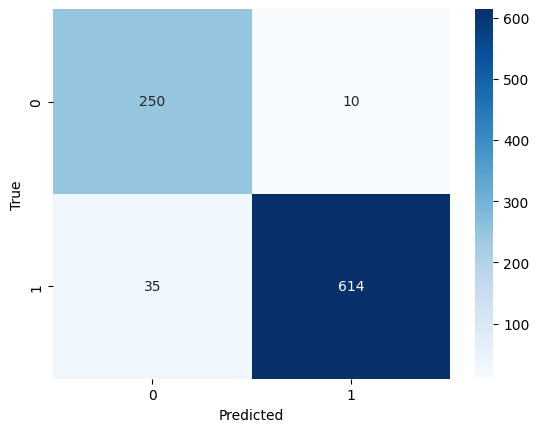

BiLSTM Test loss: 0.1181
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93       260
         1.0       0.96      0.99      0.97       649

    accuracy                           0.96       909
   macro avg       0.97      0.94      0.95       909
weighted avg       0.96      0.96      0.96       909



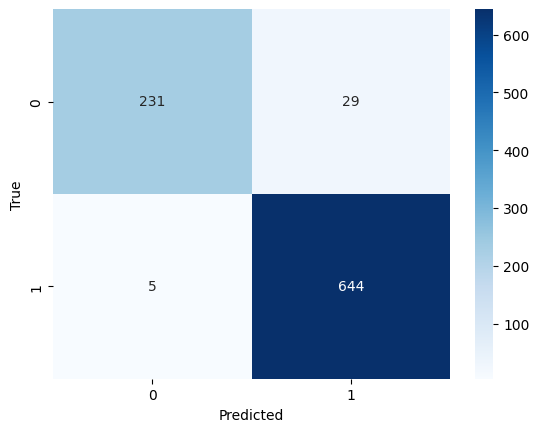

BIN: 2 - 190 samples
FC Test loss: 0.1281
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        64
         1.0       0.99      0.99      0.99       126

    accuracy                           0.99       190
   macro avg       0.99      0.99      0.99       190
weighted avg       0.99      0.99      0.99       190



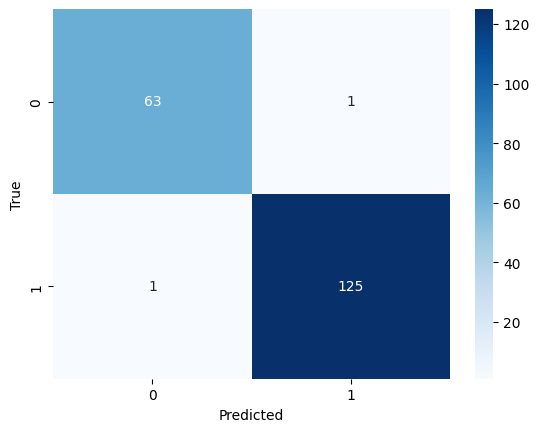

LSTM Test loss: 0.0865
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95        64
         1.0       1.00      0.94      0.97       126

    accuracy                           0.96       190
   macro avg       0.95      0.97      0.96       190
weighted avg       0.97      0.96      0.96       190



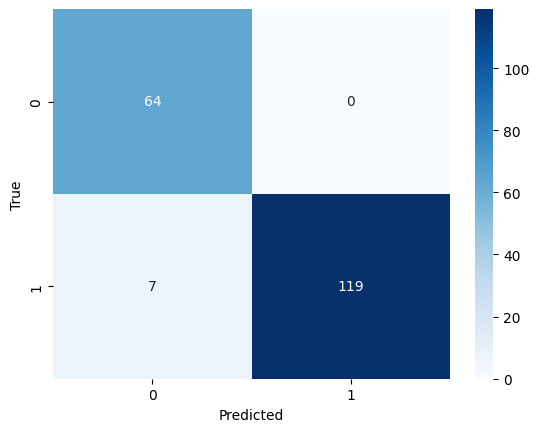

BiLSTM Test loss: 0.0761
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97        64
         1.0       0.98      0.99      0.98       126

    accuracy                           0.98       190
   macro avg       0.98      0.97      0.98       190
weighted avg       0.98      0.98      0.98       190



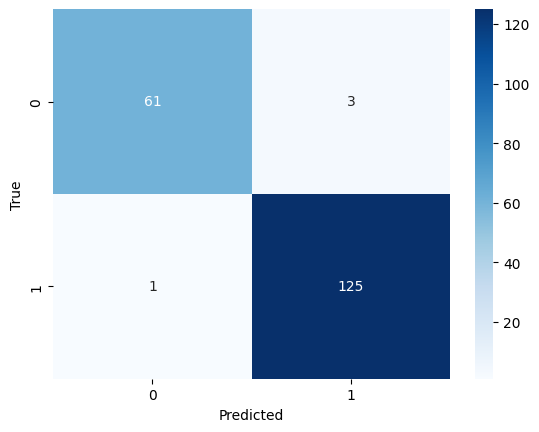

BIN: 3 - 27 samples
FC Test loss: 0.7626
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98        20
         1.0       1.00      0.86      0.92         7

    accuracy                           0.96        27
   macro avg       0.98      0.93      0.95        27
weighted avg       0.96      0.96      0.96        27



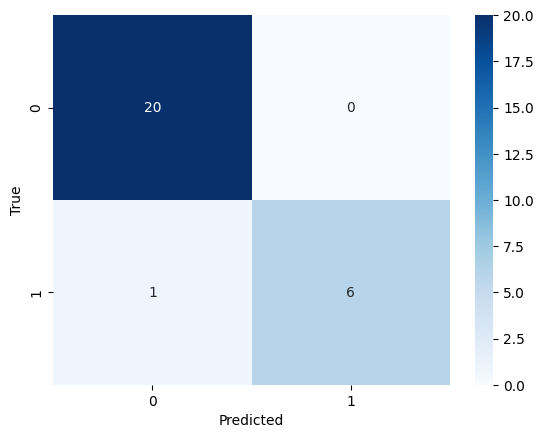

LSTM Test loss: 0.2046
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        20
         1.0       1.00      0.71      0.83         7

    accuracy                           0.93        27
   macro avg       0.95      0.86      0.89        27
weighted avg       0.93      0.93      0.92        27



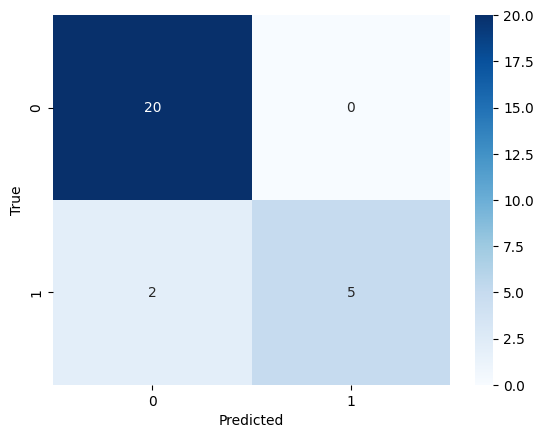

BiLSTM Test loss: 0.1844
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98        20
         1.0       1.00      0.86      0.92         7

    accuracy                           0.96        27
   macro avg       0.98      0.93      0.95        27
weighted avg       0.96      0.96      0.96        27



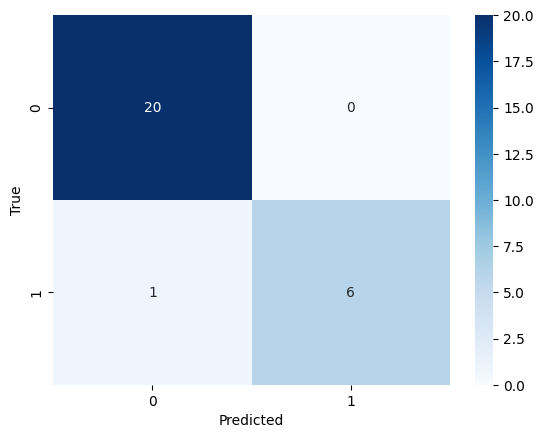

BIN: 4 - 19 samples
FC Test loss: 0.0000
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        18
         1.0       1.00      1.00      1.00         1

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



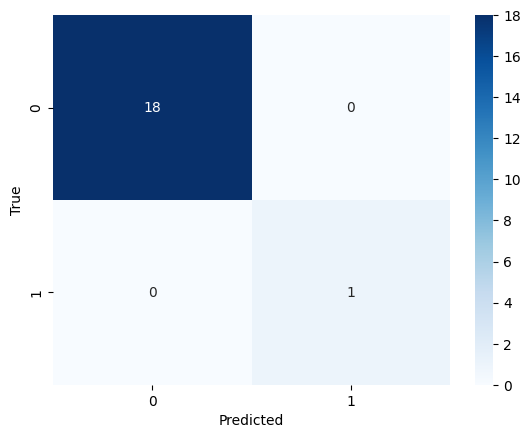

LSTM Test loss: 0.0027
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        18
         1.0       1.00      1.00      1.00         1

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



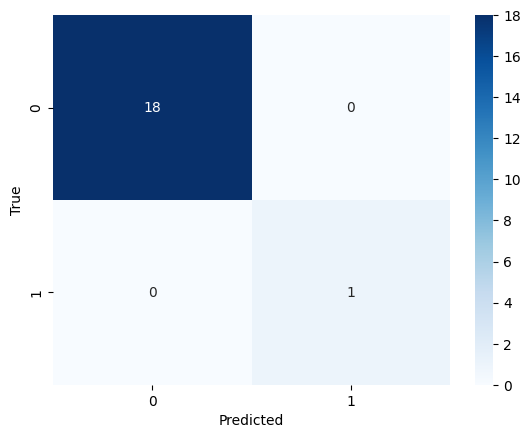

BiLSTM Test loss: 0.0008
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        18
         1.0       1.00      1.00      1.00         1

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



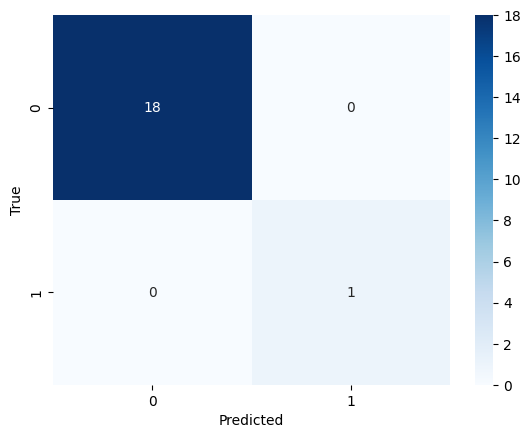

BIN: 5 - 2 samples
FC Test loss: 0.0001
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



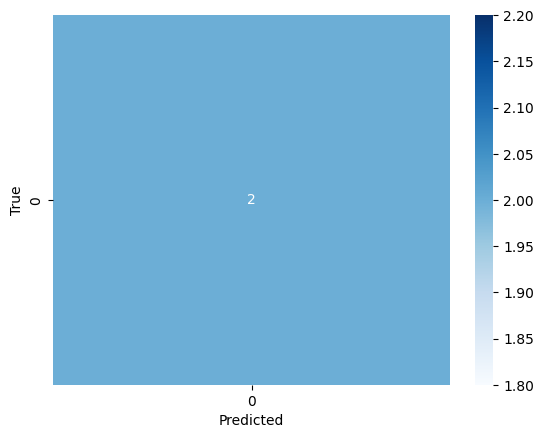

LSTM Test loss: 0.0093
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



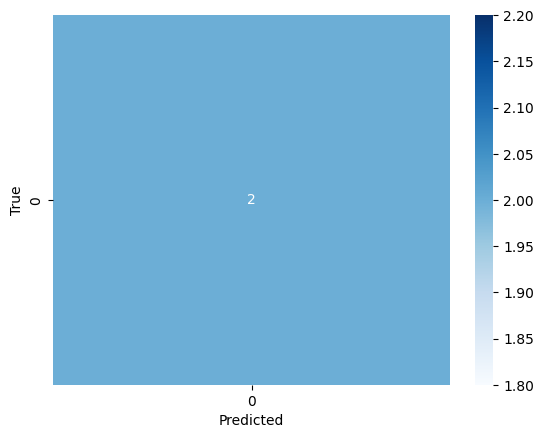

BiLSTM Test loss: 0.0561
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



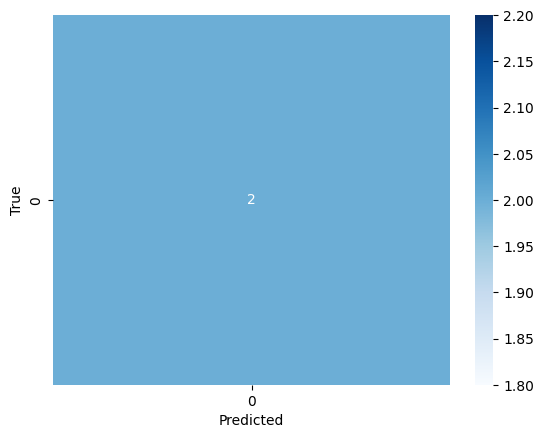

BIN: 6 - 2 samples
FC Test loss: 0.0000
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1
         1.0       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



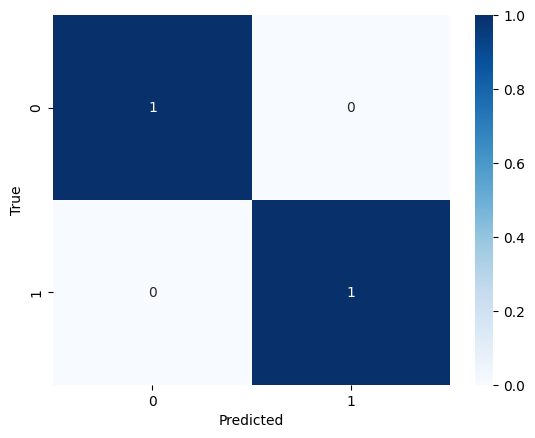

LSTM Test loss: 0.0025
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1
         1.0       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



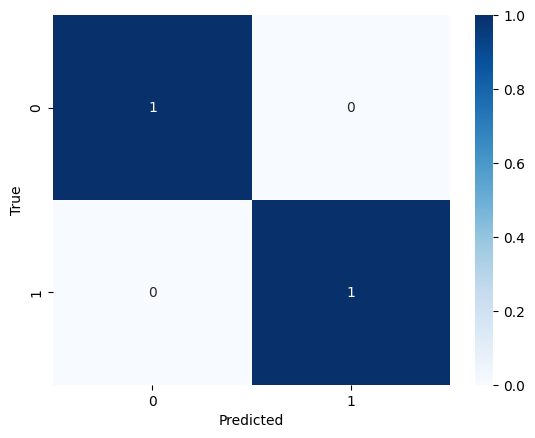

BiLSTM Test loss: 0.0004
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1
         1.0       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



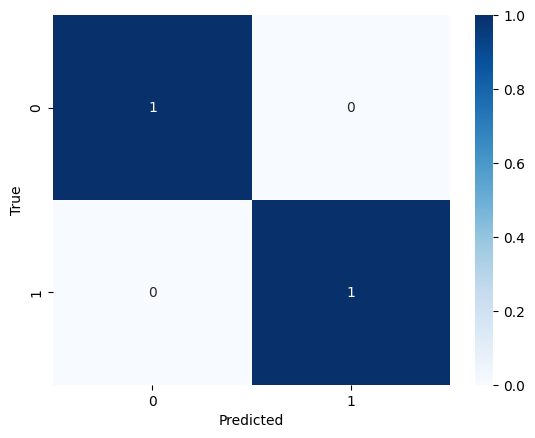

In [27]:
for i, dataset in enumerate(bins_datasets):
    if len(dataset) < 2:
        continue
    print(f'BIN: {i} - {len(dataset)} samples')
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    loss, y_pred, y_true = test_fc(fc, loader, criterion)
    print(f'FC Test loss: {loss:.4f}')
    evaluate(y_true, y_pred)
    loss, y_pred, y_true = test_seq(lstm_net, lstm, loader, criterion)
    print(f'LSTM Test loss: {loss:.4f}')
    evaluate(y_true, y_pred)
    loss, y_pred, y_true = test_seq(bilstm_net, bilstm, loader, criterion)
    print(f'BiLSTM Test loss: {loss:.4f}')
    evaluate(y_true, y_pred)
    print('=' * 120)

For longer sequences, Bidirectional LSTM gets better results than LSTM. This is because Bidirectional LSTM is capturing the sequential nature of the data in both directions while LSTM is capturing the sequential nature of the data in one direction and this causes LSTM to forget information from the beginning of the sequence while Bidirectional LSTM does not forget information from the beginning of the sequence. Fully Connected Neural Network gets better results than LSTM and Bidirectional LSTM. This is because Fully Connected Neural Network is able to capture the whole data without forgetting. But inputting the whole data into Fully Connected Neural Network is computationally expensive. If this assignment were to only input the output of the last LSTM cell into Fully Connected Neural Network, then a Fully Connected Neural Network of same parameter count would get worse results than LSTM and Bidirectional LSTM. This is because LSTM and Bidirectional LSTM are able to capture the sequential nature of the data while Fully Connected Neural Network is not able to capture the sequential nature of the data.

In higer bins we see BiLSTM performing better than LSTM and in all of them FC is performing better than LSTM and BiLSTM.